In [2]:
import pandas as pd
import numpy as np

from sklearn import preprocessing

# Data Science For Business Project

> Contributors: `Genolet Robin` and `Rodrigues Alves Danny`

Notebook's organisation:

*  [Step 1](#step1)
  * [Preprocessing](#preprocessing1)
  * [Models](#models1)
  * [Models comparison](#modelscomparison1)
  * [Unseen datasets](#unseen1)

*  [Step 2](#step2)
  * [Preprocessing](#preprocessing2)
  * [Models](#models2)
  * [Models comparison](#modelscomparison2)
  * [Unseen datasets](#unseen2)
  
*  [Step 3](#step3)
  * [Preprocessing](#preprocessing3)
  * [Models](#models3)
  * [Models comparison](#modelscomparison3)
  * [Unseen datasets](#unseen3)
*  [Conclusion](#conclusion)

# <a name="step1"></a> Step 1

> Predict the category of each product, based on the reviewText field. View the problem as a multiclass classification (24 product categories).
>
> f(`reviewText`) -> category

## <a name="preprocessing1"></a> Preprocessing

In [3]:
# Load file (we keep the git repo as light as possible by only hosting the .gz's)
!rm -f *.json
!gunzip -c amazon_step1.json.gz > amazon_step1.json

# A first look at the data
df1 = pd.read_json('amazon_step1.json', lines=True)
df1.head()

,asin,category,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000J4HXUC,Sports_and_Outdoors,"[1, 1]",5,It's a .50 Caliber Ammo Can. That largely sums...,"01 5, 2014",A3QRW0UJPKIAX7,Grant Fritchey,Clean and Exactly as Advertised,1388880000
1,0983393214,Books,"[0, 0]",5,This was a very good book. It kept me excited ...,"06 23, 2013",A2SEIOM4H06WTH,TJ,Great read!,1371945600
2,B003G4FVMY,Grocery_and_Gourmet_Food,"[0, 0]",5,"If you love coconut the way I do, you can't go...","05 19, 2013",A3GDEXMU9587JX,"K. Parsley ""kindlekat""","If you love coconut, get this coffee",1368921600
3,B00F9VRNF0,Cell_Phones_and_Accessories,"[0, 0]",5,I recently switched from the Galaxy S3 to the ...,"04 25, 2014",ASP3J2NEHDN4E,ChriS,Superior Protection!!!,1398384000
4,B00D5OZQUC,Amazon_Instant_Video,"[0, 0]",5,"Good show,looks like the gap from season 2 to ...","11 4, 2013",A1EDBI6TBKP9CO,Grants Book Trade,"Love the show, thanks for putting Season 3 on ...",1383523200


In [4]:
# Features name and type
df1.dtypes

asin              object
category          object
helpful           object
overall            int64
reviewText        object
reviewTime        object
reviewerID        object
reviewerName      object
summary           object
unixReviewTime     int64
dtype: object

In [5]:
# For python2 kernel:
from __future__ import division
# Analyze the data: features and sample
num_total_samples = len(df1.index)
num_total_features = len(df1.columns)
print("Number of features:", num_total_features)
print("Number of samples:", num_total_samples)

('Number of features:', 10)
('Number of samples:', 96000)


In [6]:
# Start by counting the number of valid entrie per sample
num_valid_entries_per_sample = df1.count(axis=1)
# Then compute the total number of complete samples
num_complete_samples = num_valid_entries_per_sample.tolist().count(num_total_features)

# We can now compute the percenter of damaged sample
percentage_damaged_samples = 1 - num_complete_samples/num_total_samples
print('Number of damaged samples:', num_total_samples - num_complete_samples)
print('Percentage of damaged Samples:', np.around(100*percentage_damaged_samples,decimals=1), '%')

('Number of damaged samples:', 994)
('Percentage of damaged Samples:', 1.0, '%')


It appears that we have some missing data. <br />
Let's see the number of valid entries for each feature

In [7]:
num_valid_entries_per_feature = df1.count(axis=0).sort_values()
print("Number of valid entrie perf feature: ")
print(num_valid_entries_per_feature)

Number of valid entrie perf feature: 
reviewerName      95006
asin              96000
category          96000
helpful           96000
overall           96000
reviewText        96000
reviewTime        96000
reviewerID        96000
summary           96000
unixReviewTime    96000
dtype: int64


Only `reviewerName` is sometimes missing (994 times to be precise). We will see how to deal with it later.

In [8]:
df1.isnull().sum()

asin                0
category            0
helpful             0
overall             0
reviewText          0
reviewTime          0
reviewerID          0
reviewerName      994
summary             0
unixReviewTime      0
dtype: int64

### We now present the preprocessing choices for each features

As stated in the project description, we will mainly rely on the **reviewText** feature. Nevertheless, we decide to take a look into each other feature and try to see if we can extract some useful information from them in order to improve our models.

### asin
> Defintion: `amazon standard identification number which is unique for each product`

This feature will obvisously not bring useful information for the task we want to perform. We drop it. Another option would have been to use it as the index for each row, but we decided to go with the regular incremental index from pandas dataframe.

In [9]:
df1 = df1.drop(['asin'], axis=1)

### category
> Definition: `category of the product`

This is the target feature for part I of the project.<br />
We see below that the frequency of each category is equal<br />
This is a great news since we will be able to use a simple accuracy score to rank our different models.<br />
Moreover, it will be easy to sample a subset of the dataset if need be (e.g. to test a model on small data to improve speed).

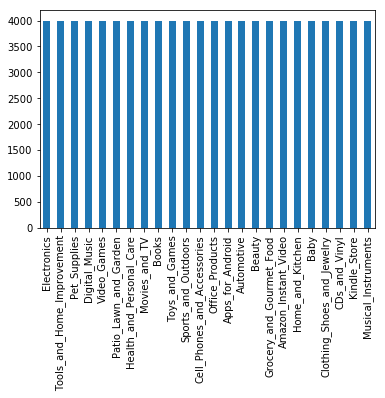

In [10]:
import matplotlib.pyplot as plt
df1["category"].value_counts().plot(kind='bar')
plt.show()

### helpful
> Definition: `[x,y]: x is the number of helpful ticks and y is the number of total ticks`

This features is not useful in it's actual form, but we think that we can take advantage of the information it contains. Indeed, it's reasonable to think that a five stars product might have a bigger ratio x/y than a one start product. Therefore, we decide to create a new feature from the *helpful* one: **helpfulPercentage**.

In [11]:
from ast import literal_eval
from sklearn.preprocessing import StandardScaler

# Compute the new feature 'helpfulPercentage'
def createHelpfulPercentage(df):
    # First, check if the column 'helpful' is a list or not. If not, convert it.
    if not isinstance(df.helpful[0], list):
        df.helpful = df.helpful.apply(literal_eval)
    df["helpfulPercentage"] = df.helpful.apply(lambda x: x[0]/x[1] if x[1] != 0 else 0)

createHelpfulPercentage(df1)

# Standardize the feature
scalerHelpful = StandardScaler()
df1.helpfulPercentage = scalerHelpful.fit_transform(df1.helpfulPercentage.values.reshape(-1,1))

# Remove the 'old' one
df1 = df1.drop(["helpful"], axis=1)

df1.helpfulPercentage.sample(5)

13987    1.176272
82548    0.900858
48084    1.561853
51227   -0.751631
30475    1.561853
Name: helpfulPercentage, dtype: float64

> Notice that to standardize the newly created feature, we use a **StandardScaler** object and not the *scale()* method from sklearn. Both ways result in the same result, but with the StandardScaler object, we will be able to reuse it, already trained or *fit*, with the unseen data

### overall
> Definition: `overal rating of the product in the range of [1,2,3,4,5]`

This is the target feature for parts II and II of the project

We can see that the mean for each category are quite close one to the other and except for the category *Apps_for_Android*, they are all above 4 (apparently, people rate products positevely). It also means that the data will be skewed for step 3.

category
Amazon_Instant_Video           4.21125
Apps_for_Android               3.96325
Automotive                     4.45325
Baby                           4.22200
Beauty                         4.18700
Books                          4.26575
CDs_and_Vinyl                  4.27800
Cell_Phones_and_Accessories    4.12600
Clothing_Shoes_and_Jewelry     4.25000
Digital_Music                  4.22650
Electronics                    4.23575
Grocery_and_Gourmet_Food       4.25825
Health_and_Personal_Care       4.24675
Home_and_Kitchen               4.32525
Kindle_Store                   4.35850
Movies_and_TV                  4.12200
Musical_Instruments            4.49550
Office_Products                4.34450
Patio_Lawn_and_Garden          4.21875
Pet_Supplies                   4.22325
Sports_and_Outdoors            4.40150
Tools_and_Home_Improvement     4.35275
Toys_and_Games                 4.38350
Video_Games                    4.09725
Name: overall, dtype: float64


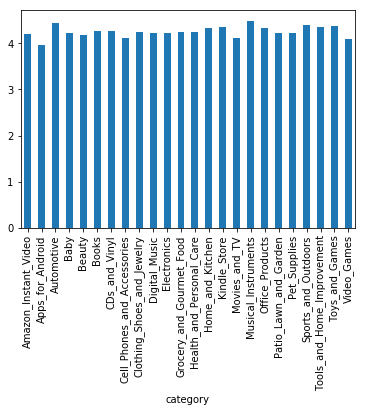

In [12]:
print(df1.groupby("category")["overall"].mean())

df1.groupby("category")["overall"].mean().plot(kind='bar')
plt.show()

### reviewText
> Definition: `text of the review`

This is the main feature on which we need to rely on. It's text, so we need to transform it into a numerical form.

But before doing so, we decided to extract some information from this feature.

Firstly, we create a new feature **reviewTextLenght**. The name describe perfectly the feature.

In [13]:
# Compute the feature
def createTextLength(df, feature):
    name = feature + "Length"
    df[name] = df[feature].apply(lambda x: len(x))
    df[name] = pd.to_numeric(df[name])
    
createTextLength(df1, "reviewText")

# Standardize the new feature
scalerTextLength = StandardScaler()
df1.reviewTextLength = scalerTextLength.fit_transform(df1.reviewTextLength.values.reshape(-1,1))

df1.reviewTextLength.sample(5)

/root/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


56079   -0.631406
77418   -0.626515
9270     0.580363
41022    0.872606
39613   -0.430871
Name: reviewTextLength, dtype: float64

We also create features that capture the amount of punctuation that is used, namely **points**, **exclamation marks**, **question marks**, and **comas**. 

In [14]:
def count_char(row, char):
    return row.count(char)

def createTextPunctuationFeatures(df, feature):
    df[feature+"CountPoints"] = df[feature].apply(count_char, args=("."))
    df[feature+"CountExcl"] = df[feature].apply(count_char, args=("!"))
    df[feature+"CountInterr"] = df[feature].apply(count_char, args=("?"))
    df[feature+"CountComas"] = df[feature].apply(count_char, args=(","))

createTextPunctuationFeatures(df1, "reviewText")


# Standardize all new features
scalerCountPoints = StandardScaler()
scalerCountExcl = StandardScaler()
scalerCountInterr = StandardScaler()
scalerCountComas = StandardScaler()

df1.reviewTextCountPoints = scalerCountPoints.fit_transform(df1.reviewTextCountPoints.values.reshape(-1,1))
df1.reviewTextCountExcl = scalerCountExcl.fit_transform(df1.reviewTextCountExcl.values.reshape(-1,1))
df1.reviewTextCountInterr = scalerCountInterr.fit_transform(df1.reviewTextCountInterr.values.reshape(-1,1))
df1.reviewTextCountComas = scalerCountComas.fit_transform(df1.reviewTextCountComas.values.reshape(-1,1))


# Output some sample
df1[["reviewTextCountPoints", "reviewTextCountExcl", "reviewTextCountInterr", "reviewTextCountComas"]].sample(5)

,reviewTextCountPoints,reviewTextCountExcl,reviewTextCountInterr,reviewTextCountComas
12462,-0.362196,-0.341411,-0.218245,-0.441073
45215,-0.578953,-0.341411,-0.218245,-0.187700
56545,-0.362196,-0.341411,-0.218245,-0.567760
6141,-0.470575,0.772321,-0.218245,-0.567760
40647,-0.470575,-0.341411,-0.218245,-0.441073


Another created features, that we think is useful to detect a sentiment in a text: presence of smileys in the text

In [15]:
# Build two new features in relation with the presence of smileys in a textual feature
# Return 'True' if a smiley is in the text, 'False' otherway
def contains_smiley(df, feature):
    df[feature+"PositiveSmiley"] = df[feature].apply(lambda x: 1 * ((":)" in x) or (":D" in x) or (";)" in x) ))
    df[feature+"NegativeSmiley"] = df[feature].apply(lambda x: 1 * (":(" in x) )

contains_smiley(df1, "reviewText")

# Since this is a boolean feature (0 or 1), no need to standardize

df1[["reviewTextPositiveSmiley", "reviewTextNegativeSmiley"]].sample(5)

,reviewTextPositiveSmiley,reviewTextNegativeSmiley
6959,0,0
63170,0,0
25953,0,0
78568,0,0
58380,0,0


Another feature that we think may have an impact on the sentiment of the review: presence of words written in capital letters.

In [16]:
# Build a new feature into a dataframe: 'AllCAPS'. 
#This feature will be created from a textual feature (the argument 'feature')
def createALLCAPS(df, feature):
    
    # Return True is the given string contains a words with only capital letters
    # and if that word is composed of more than 3 characters (avoid acronymns, or sentence start like 'A')
    def containsALLCAPSword(string):
        containsUpper = False
        for w in string.split(' '):
            if (w.isupper() and len(w)>3):
                containsUpper = True
                break
        return containsUpper
    
    df[feature+"AllCAPS"] = df[feature].apply(lambda x : containsALLCAPSword(x))

# Create the new feature. Again boolean feature, no need to standardize
createALLCAPS(df1, "reviewText")

df1.reviewTextAllCAPS.sample(5)

1002      True
41915    False
1399     False
57226    False
8127      True
Name: reviewTextAllCAPS, dtype: bool

Now that we have built all desired new features from the textual feature `reviewText`, we will need to transform this feature into a numercial one. For this, we will tokenize the features, apply english stop-words removing, use stemming and compute the TF-IDF score for each token. 

Since this type of operation will be use often through this notebook, we decide to build a pipeline transforming textual features into a numerical one.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import EnglishStemmer

In [18]:
stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()

# Function applying stemming
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

# Reviews are written in english
stop_words = 'english'

# We tokenize all the words, removing stop words (for english language) and then compute a TF-IDF score for each token
pipe_modified = Pipeline([('vectorize_stem', CountVectorizer(stop_words=stop_words,analyzer=stemmed_words, min_df=5, max_df=0.8)),
                          ('compute_tfidf', TfidfTransformer())])

### reviewTime
> Definition: `time of writing the review in normal format`

We think that we cannot retrieve useful information from this features. We decide to drop it.

In [19]:
df1 = df1.drop(["reviewTime"], axis=1)

### reviewerID
> Definition: `id of the reviewer`

We decide to drop this feature. Nevertheless, we think that some possible intersting information may be hide with `reviewerID`. 

We didn't do it for this project, but we think that creating a feature from the `reviewerID` may be a good idea. Some people only rate products for a certain category. For example, a librarian will probably rate more often Books than Pet Supplies. Following that idea, we can create 24 new features, one per category. Each of these feature will correspond to the percentage of reviews that this user did, compare to all others classes.

### reviewerName
> Definition: `name of the reviewer`

We decide to drop this feature, as it is redundant with the reviewerId. *(Note that some revierID are asociated with several reviewerNames, but we don't need to deal with it.)*

> Since we drop this feature, no need to taking care of the missing values.

In [20]:
# Compute the number of different names used per 'reviewerIDs'
names_per_id = df1.groupby('reviewerID')["reviewerName"].unique()
names_count = names_per_id.apply(lambda x : len(x))
names_count.sort_values(ascending=False)

reviewerID
A2DG63DN704LOI           3
A3R5GTYQ50QVMD           3
AAV45IBIJCSWN            3
AWJBO5XGIW8ZS            2
A3SJNPFFJIPT4U           2
A1S0D037M0D71X           2
A70NFM6KHU24F            2
AX47EVO5R71HI            2
A2FTHCGH06O4Y5           2
AJC1CRUPPTWNW            2
A2NCWLAWOVCKF7           2
AFICF7DKHTQ87            2
A3D4YTF8EL8YKH           2
A1AHJMZVJUR1GC           2
A13GFMDEPD0776           2
ADDT2MU773IYL            2
A2SZ4Q10WWZZO7           2
A2I98OOPNIJNYY           2
A1M7VLUUTO1NRL           2
A3IEAYDS24L2IK           2
AYUJYN6K5UBKM            2
AZFODJ6KW6KQH            2
A3PBPEFMYAX0CT           2
A1JRD2Z3ESN8E9           2
A3NGABXDIB0POU           2
A3SI53R6YBH1XW           2
A15PUBCS4N4G60           2
A2EN82VBJT44QP           2
A11FWFZNI2VQT            2
ACDJL2NYQL0GT            2
                        ..
A3JA893PH2V0F7           1
A3JB45FLJWJ563           1
A3JAVLC91VL5KE           1
A3JASVF01JUMV8           1
A3JAROGQ2RN6L2           1
A3JAR8K4EF94ZO   

In [21]:
df1 = df1.drop(["reviewerID", "reviewerName"], axis=1)

### summary
> Defintion: `a summary of reviewer's opinion about the product`

Let's look at this feature, with the **reviewText** next to it.

As for the reviewText, we think that thise feature is really useful. We will be able to use the same pipeline as for `reviewText` to transform this feature to a numerical one. Also, we can create the same type of features from `summary` that we did for `reviewerText` ! We will do so for the step 2 & 3

In [22]:
df1[["reviewText", "summary"]]

,reviewText,summary
0,It's a .50 Caliber Ammo Can. That largely sums...,Clean and Exactly as Advertised
1,This was a very good book. It kept me excited ...,Great read!
2,"If you love coconut the way I do, you can't go...","If you love coconut, get this coffee"
3,I recently switched from the Galaxy S3 to the ...,Superior Protection!!!
4,"Good show,looks like the gap from season 2 to ...","Love the show, thanks for putting Season 3 on ..."
5,"I'm ordering more of these spoons, as one just...",Perfect for babies
6,We installed some sensor lights in the house f...,"Nice little sensor light, good for power fail..."
7,It was 1979 and the B-52s were on Saturday Nig...,Defining An Era
8,My Manchester terrier eats so fast she chokes ...,Perfect Solution For Dogs That Gobble Food Too...
9,This movie starts off with some clever and fun...,Reverse Cinderella just doesn't cut it.


### unixReviewTime
> Definition: `time of writing the review in UNIX format`

This feature is redudant with **reviewTime**. We also drop it.

In [23]:
df1 = df1.drop(["unixReviewTime"], axis=1)

### Preprocessing results
We give below an overview of the final data frame that we will be using.

In [24]:
df1.head()

,category,overall,reviewText,summary,helpfulPercentage,reviewTextLength,reviewTextCountPoints,reviewTextCountExcl,reviewTextCountInterr,reviewTextCountComas,reviewTextPositiveSmiley,reviewTextNegativeSmiley,reviewTextAllCAPS
0,Sports_and_Outdoors,5,It's a .50 Caliber Ammo Can. That largely sums...,Clean and Exactly as Advertised,1.561853,-0.106836,0.396455,-0.341411,-0.218245,-0.187700,0,0,False
1,Books,5,This was a very good book. It kept me excited ...,Great read!,-0.751631,-0.627738,-0.470575,-0.341411,-0.218245,-0.567760,0,0,False
2,Grocery_and_Gourmet_Food,5,"If you love coconut the way I do, you can't go...","If you love coconut, get this coffee",-0.751631,-0.547035,-0.687332,0.215455,-0.218245,-0.441073,0,0,False
3,Cell_Phones_and_Accessories,5,I recently switched from the Galaxy S3 to the ...,Superior Protection!!!,-0.751631,1.256557,1.155105,1.886052,-0.218245,-0.314387,0,0,True
4,Amazon_Instant_Video,5,"Good show,looks like the gap from season 2 to ...","Love the show, thanks for putting Season 3 on ...",-0.751631,-0.573936,-0.578953,-0.341411,2.760569,-0.187700,0,0,False


### Training, tuning and testing of models

In [25]:
# The target feature --> CATEGORY
y = df1.category

In [26]:
# Features to transfrom from textual to numerical representation: REVIEWTEXT and SUMMARY
# ---- ReviewText
pipe_modified.fit(df1.reviewText)
x_reviewText = pipe_modified.transform(df1.reviewText)

# ---- Summary
pipe_modified.fit(df1.summary)
x_summary = pipe_modified.transform(df1.summary)

> Note that for this first step, we decide to not use the features we create. Firstly, those features are more related to the sentiment of the text. We think that to find out the category of the product, the sentiment will not be part of. But since we are in the Data science world, we cannot only rely on our simple assumption. So we try with and without the new features. We test with the SVC model and without the features the model was better.

In [27]:
# Now we can combine all features into a single dataframe
from scipy.sparse import hstack

# Combine first the two `sparse matrix` filled with the TF-IDF scores 
X = hstack((x_reviewText, x_summary))

In [28]:
X.shape

(96000, 26180)

In [29]:
# Now we divided the feature into two sets: a trainin set and another one for testing. 
# Training set = 80% of the entire data
# Testing set  = 20% of the entire data

from sklearn.cross_validation import train_test_split
seed = 2017
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

/root/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [30]:
# Train
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

# Test
print("X_test:  ", X_test.shape)
print("y_test:  ", y_test.shape)

('X_train: ', (76800, 26180))
('y_train: ', (76800,))
('X_test:  ', (19200, 26180))
('y_test:  ', (19200,))


## <a name="models1"></a> Models

For each step, we will try five different models:

* Dummy Classifier
* Linear Support Vector Classification
* SGD
* K-nearest neighbors 
* Random forest classifier

For some of those models, we will use a *Grid search* to optimize the parameters to use

In [129]:
from sklearn.metrics import confusion_matrix
import itertools

# We define an helper function to compute and print the precision of our models
# Since we are dealing with a classifier, we decide to print only the 'precision? of the models
# Therefore, we don't use recall, f measure and support
def print_precision(y_t, y_pred):
    p_and_rec=precision_recall_fscore_support(y_t,y_pred)
    precision = p_and_rec[0]
    recall = p_and_rec[1]
    f_measure = p_and_rec[2]
    support = p_and_rec[3]
    print("Precision mean: ", np.mean(precision))

# Prints a colorful confusion matrix
# Adapted from
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 2.
    

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
def print_confusion_matrix(y_test, y_pred, n_class):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    # Plot normalized confusion matrix
    plt.figure()
    # Hack, only 28mins left
    if n_class == 24:
        cc = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 16, 18, 19, 20, 21, 22, 23]
    elif n_class == 2:
        cc = [0, 1]
    elif n_class == 5:
        cc = [0, 1, 2, 3, 4]
    plot_confusion_matrix(cnf_matrix, classes=cc, normalize=True,
                          title='Normalized confusion matrix')
    plt.show()

### Baseline model (Dummy Classifier)

In [60]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.dummy import DummyClassifier
baselineModel = DummyClassifier(random_state=seed)
baselineModel.fit(X_train,y_train)
y_pred = baselineModel.predict(X_test)

print_precision(y_test, y_pred, 24)
print("1 / 24 = ", 1/24)

('Precision mean: ', 0.044706184620732059)
('1 / 24 = ', 0.041666666666666664)


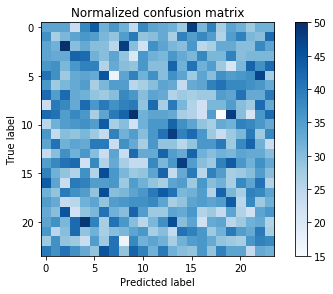

In [67]:
from sklearn.metrics import confusion_matrix
import itertools
print_confusion_matrix(y_test, y_pred, 24)

The baseline model has a precision that is close to 1/24. This is completly normal, since we have 24 features !<br />
The confusion matrix has a random look, as expected.

In [33]:
baseline_precision = 0.0447061846207

### Support Vector Model: Linear Support Vector Classification

In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# setup pipeline
estimators = []
estimators.append(('svm_clf', LinearSVC()))
pipe = Pipeline(estimators)

# tuning requsted parameter
tuned_parameters = [{'svm_clf__C': np.logspace(-5,15,11,base=2.0)}]
clf = GridSearchCV(pipe, tuned_parameters, cv=5, scoring='accuracy')

run = False
if run:
    # Speed up computation: with only a subset of the training data for Grid search
    subset_size = 10000
    clf.fit(X_train[:subset_size],y_train[:subset_size])
    print(clf.best_params_)
else:
    print("{'svm_clf__C': 0.125}")

{'svm_clf__C': 0.125}


In [69]:
# bect C value resulting from GridSearch
best_C = 0.125

In [70]:
svc = LinearSVC(C=best_C)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print_precision(y_test, y_pred)

('Precision mean: ', 0.76137184873449038)


In [71]:
svc_precision = 0.761371848734

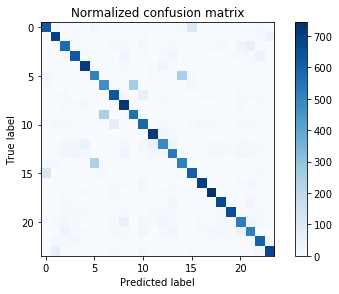

In [72]:
print_confusion_matrix(y_test, y_pred, 24)

### Linear Model:  Stochastic Gradient Descent

In [73]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.001, 0.0001, 0.00001, 0.000001]
}
cv = KFold(n_splits=10, random_state=seed)
sgd = GridSearchCV(SGDClassifier(loss="hinge", random_state=seed), parameters,
     scoring="accuracy", cv=cv)

# Takes approximately 15 minutes to run with our machines
runGridSearch = False
if (runGridSearch):
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.001, random_state=seed)
    X_train_s1, X_test_s1, y_train_s1, y_test_s1 = train_test_split(X_train_s, y_train_s, test_size=0.2, random_state=seed)
    sgd.fit(X_train_s1, y_train_s1)
    print("Best params:", sgd.best_estimator_.get_params())
else:
    # Copy/Paste from the results of the 'if' block
    print("Best params: {'alpha': 1e-05, 'average': False, 'class_weight': None, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, \
          'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_iter': 5, 'n_jobs': 1, 'penalty': 'l1', 'power_t': 0.5, 'random_state': 2017, 'shuffle': True, 'verbose': 0, 'warm_start': False}")

Best params: {'alpha': 1e-05, 'average': False, 'class_weight': None, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True,           'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_iter': 5, 'n_jobs': 1, 'penalty': 'l1', 'power_t': 0.5, 'random_state': 2017, 'shuffle': True, 'verbose': 0, 'warm_start': False}


In [74]:
# Build the SGDClassifier with the best params return by grid search
sgd = SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15, learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1, penalty='l1', power_t=0.5, random_state=2017, shuffle= True, verbose=0, warm_start=False)

# Predict testing data
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
print_precision(y_test, y_pred)

('Precision mean: ', 0.73438582847698797)


In [76]:
SGD_precision = 0.734385828477

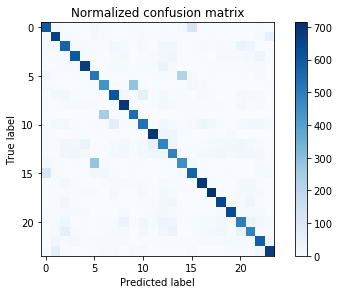

In [77]:
print_confusion_matrix(y_test, y_pred, 24)

### Similarity-based model: KNN Classifier

In [78]:
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV

In [79]:
from sklearn.neighbors import KNeighborsClassifier
estimators = []
estimators.append(('knn_clf', KNeighborsClassifier()))
knn_clf_pipe = Pipeline(estimators)
knn_clf_pipe.set_params(knn_clf__algorithm='brute')
knn_clf_pipe.set_params(knn_clf__weights='distance')

# create a grid search over n_neighbors values
# We decided to test from a large variety of neighbors possible. To speed up the computation time, we didn't test all possibilities, but use a step between each number
parameters = {
        'knn_clf__n_neighbors' : range(1,151,10)
}
estimator_knnclf = GridSearchCV(knn_clf_pipe, parameters, cv=5)

run = False
if run:
    # With our machines, we had several memory errors. Therefore we decide to use less data in order to have some results
    subset_size = 10000
    # evaluate the grid search and print best regressor
    estimator_knnclf.fit(X_train[:subset_size], y_train[:subset_size])
    print(estimator_knnclf.best_estimator_)
else:
    # Copy/Paste from the results of the 'if' block
    print("Pipeline(steps=[('knn_clf', KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',\
           metric_params=None, n_jobs=1, n_neighbors=61, p=2,\
           weights='uniform'))])")

Pipeline(steps=[('knn_clf', KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',           metric_params=None, n_jobs=1, n_neighbors=61, p=2,           weights='uniform'))])


In [80]:
# best number of neighbors obtained using GridSearchCV
best_clf_neighbors = 61

In [81]:
# fix the number of neighbors to the best value
knn_clf_pipe.set_params(knn_clf__n_neighbors=best_clf_neighbors)

# fit the model to the training set
knn_clf_pipe.fit(X_train, y_train)

y_pred = knn_clf_pipe.predict(X_test[:1000])
print_precision(y_test[:1000], y_pred)

('Precision mean: ', 0.47742667436221681)


In [82]:
knn_precision = 0.477426674362

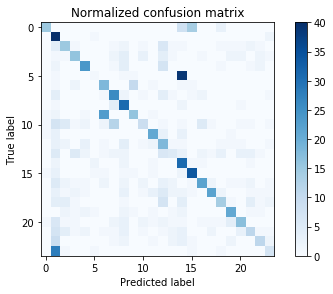

In [84]:
print_confusion_matrix(y_test[:1000], y_pred, 24)

### Information Based model: Random Forest Classifier

In [85]:
from sklearn.ensemble import RandomForestClassifier
tuned_parameters = {
    'n_estimators': range(1,801,100),
    'max_depth': range(1,101,20)
    }

rf_clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, scoring='accuracy')

run = False
if run:
    # As for before, we need to use less data to avoid 'memory_errors'
    subset_size = 1000
    rf_clf.fit(X_train[:subset_size],y_train[:subset_size])
    print(rf_clf.best_params_)
else:
    print("{'max_depth': 41, 'n_estimators': 701}")

{'max_depth': 41, 'n_estimators': 701}


In [86]:
tuned_parameters = {
    'n_estimators': range(602,801,30),
    'max_depth': range(32,51,5)
    }

rf_clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, scoring='accuracy')

run = False
if run:
    # As for before, we need to use less data to avoid 'memory_errors'
    subset_size = 1000
    rf_clf.fit(X_train[:subset_size],y_train[:subset_size])
    print(rf_clf.best_params_)
else:
    print("{'max_depth': 42, 'n_estimators': 752}")

{'max_depth': 42, 'n_estimators': 752}


In [87]:
best_n_estimators = 752
best_clf_tree_depth = 42

In [88]:
rf_clf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_clf_tree_depth)

# As for before, we need to use less data to avoid 'memory_errors' and speed up the all computation
subset_size = 10000
rf_clf.fit(X_train[:subset_size],y_train[:subset_size])

y_pred = rf_clf.predict(X_test)
print_precision(y_test, y_pred)

('Precision mean: ', 0.62913790136827785)


In [90]:
randomForest_precision = 0.630331140822

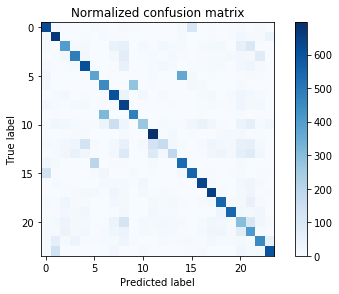

In [92]:
print_confusion_matrix(y_test, y_pred, 24)

This model is both very slow and underperfomes.

## <a name="modelscomparison1"></a> Models comparison
We rank our models by the accuracy it achieved with the test data.

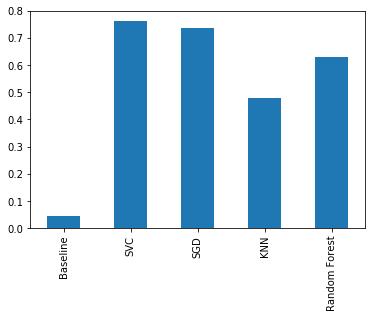

In [93]:
models_precision = [baseline_precision, svc_precision, SGD_precision, knn_precision, randomForest_precision]
models = ["Baseline", "SVC", "SGD", "KNN", "Random Forest"]

models_df = pd.DataFrame(models_precision, models)
models_df[0].plot(kind='bar')
plt.show()

In [94]:
models_precision

[0.0447061846207,
 0.761371848734,
 0.734385828477,
 0.477426674362,
 0.630331140822]

As we can see, the two linear models perform the best among the others. We will use the **SVC model** to predict the unseen data, as it performs better with our test data. 

Compare to the baseline model, we can observe that our models aren't bad ! Almost 80% of accuracy for a 24 classes classifier is an acceptable result in our opinion.

## <a name="unseen1"></a>Prediction of the unseen data

In [95]:
# We will apply the same modification as for the preprocessing step for this new dataset

!gunzip -c amazon_step1_unseen.csv.gz > amazon_step1_unseen.csv
df1_unseen = pd.read_csv("amazon_step1_unseen.csv")

df1_unseen.sample(5)

,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,label
17883,17883,A3TY5FFEYD06JL,0005119367,"Diane F. Adams ""onesweetdeedee""","[1, 1]","In my opinion I think Joseph is a great movie,...",5.0,My review of Joseph,1141257600,"03 2, 2006",?
17369,17369,A3H0ZQ74ITU83J,1617160377,Mom and Teacher,"[0, 1]","This item is a great language program, but you...",5.0,Great learning tool,1299110400,"03 3, 2011",?
2192,2192,A3O1X0U1ELQICF,0123456479,Bud1108,"[0, 1]",This is a nice jewelry organizer but it's far ...,4.0,I wouldn't call it huge,1370908800,"06 11, 2013",?
18260,18260,A241RJPMBKP8JP,0739075934,"Dr. Mark Turiano ""DrBoom""","[2, 2]",I got this because I really like Billy Martin'...,5.0,Spend and afternoon with a master.,1311033600,"07 19, 2011",?
12015,12015,AQ7U2EPGHKT6J,1934653039,arlene hug,"[1, 1]",I bought this newspaper for my son for Christm...,5.0,Boston Red Sox Greatest Moments Newspaper,1360627200,"02 12, 2013",?


In [96]:
# Verifiy if this data as null values
df1_unseen.isnull().sum()

Unnamed: 0         0
reviewerID         0
asin               0
reviewerName      90
helpful            0
reviewText         7
overall            0
summary            1
unixReviewTime     0
reviewTime         0
label              0
dtype: int64

Ah ! Compare to the training dataset, this validation data has some null values within two features of interest: `reviewText` and `summary`. 

We cannot drop those rows from our dataset: we need to predict the category of the product in a way ! We decide to replace some null entries by an empty string. For example, when the `reviewText` field is missing, we hope that the `summary`feature will be enough to predit the category.

In [97]:
df1_unseen.reviewText.fillna("", inplace=True)
df1_unseen.summary.fillna("", inplace=True)

# Assert that there is no more null values within this two features
df1_unseen.isnull().sum()

Unnamed: 0         0
reviewerID         0
asin               0
reviewerName      90
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
label              0
dtype: int64

In [98]:
# TF-IDF for 'reviewText'
pipe_modified.fit(df1.reviewText)
x_reviewText = pipe_modified.transform(df1_unseen.reviewText)

# TF-IDF for 'summary'
pipe_modified.fit(df1.summary)
x_summary = pipe_modified.transform(df1_unseen.summary)

# Merge all features into a single dataframe
X_unseen = hstack((x_reviewText, x_summary))

In [99]:
# SVC Classifier gives use the best prediction accuracy, we use it 
svc = LinearSVC(C=best_C)
svc.fit(X, y)

y_unseen_pred = svc.predict(X_unseen)

> Note that for predicting the unseen data, we use the totallity of the training data !

In [100]:
# export the prediction into a file named "pred1.txt"
file = open('pred1.txt', 'w')
for item in y_unseen_pred:
  file.write("%s\n" % item)

# <a name="step2"> </a>Step 2

> Predict whether a product review has 5 stars rating or not (yes/no), based on the reviewText field. The dataset for this step is filtered down to the Digital_Music category. Construct the problem as a binary classification (rank 5: 1, others: 0).
>
> `f(reviewText) -> overall (5 or not)` 

## <a name="preprocessing2"> </a> Preprocessing

In [101]:
!gunzip -c amazon_step23.json.gz > amazon_step23.json
with open('amazon_step23.json') as f:
   content = f.readlines()

df2 = pd.read_json("".join(content), lines=True)
df2.sample(5)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
12823,B000002H72,"[1, 1]",5,"Having always seemingly been compared to ""Nirv...","10 29, 2003",A1XNPOQDLLJJU3,fetish_2000,"Surprisingly there are those, that aren&#65533...",1067385600
48618,B0007NFL18,"[3, 4]",4,Lets not kid ourselves here; there aren't many...,"03 5, 2005",A12OZZLO1QNA9M,josak,"On par, if not better, than ""Get Rich'""",1109980800
64629,B00IDXIP1M,"[1, 1]",5,&#8220;Best Day Of My Life&#8221; by American ...,"04 19, 2014",A2H3JURQZOHVMB,"Stella Carrier ""joyfulwoman2078""",Emotionally Pleasing Melody,1397865600
15278,B000002KHB,"[22, 29]",5,First of all folks. MACHINE HEAD is not the on...,"04 24, 2000",A2P0PLCR7JWWNR,"James E. Lane ""jaminjim""","THE FIREBALL WE RODE WAS MOVING,BUT NOW WE GOT...",956534400
29034,B00000JC6C,"[4, 9]",3,Why don't I like this album very much? The pr...,"09 2, 2004",ANBSW3BALFRR2,Chet Fakir,A poor mans Beach Boys via Radiohead,1094083200


In [102]:
df2.isnull().sum()

asin                0
helpful             0
overall             0
reviewText          0
reviewTime          0
reviewerID          0
reviewerName      177
summary             0
unixReviewTime      0
dtype: int64

As for the preprocessing of step 1, there is only a few samples that have null values, all with the feature `reviewerName`. As discussed earlier, this is not problem for us.

In [103]:
# Create the new features
createHelpfulPercentage(df2)
createTextLength(df2, "reviewText")
createTextPunctuationFeatures(df2, "reviewText")
contains_smiley(df2, "reviewText")
createALLCAPS(df2, "reviewText")



# Standardize with MinMaxScaler
df2.helpfulPercentage     =    scalerHelpful.fit_transform(     df2.helpfulPercentage.values.reshape(-1,1))
df2.reviewTextLength      =    scalerTextLength.fit_transform(  df2.reviewTextLength.values.reshape(-1,1))
df2.reviewTextCountPoints         =    scalerCountPoints.fit_transform( df2.reviewTextCountPoints.values.reshape(-1,1))
df2.reviewTextCountExcl           =    scalerCountExcl.fit_transform(   df2.reviewTextCountExcl.values.reshape(-1,1))
df2.reviewTextCountInterr         =    scalerCountInterr.fit_transform( df2.reviewTextCountInterr.values.reshape(-1,1))
df2.reviewTextCountComas          =    scalerCountComas.fit_transform(  df2.reviewTextCountComas.values.reshape(-1,1))


# Drop useless features
df2 = df2.drop(['asin', 'reviewTime', 'reviewerID', 'reviewerName', 'unixReviewTime', 'helpful'], axis=1)

# TF-IDF for 'reviewText'
pipe_modified.fit(df2.reviewText)
x_reviewText = pipe_modified.transform(df2.reviewText)

# TF-IDF for 'summary'
pipe_modified.fit(df2.summary)
x_summary = pipe_modified.transform(df2.summary)

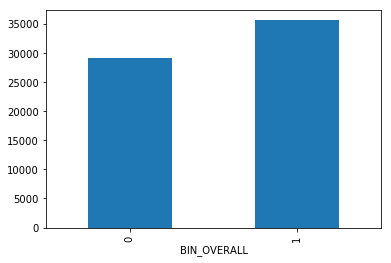

In [104]:
# Then we create BIN_OVERALL that is equal to 1 if rank is 5, and 0 otherwise
df2["BIN_OVERALL"] = 1 * (df2["overall"] == 5)
y = df2.BIN_OVERALL

# Plot the number of samples per class
df2.groupby("BIN_OVERALL").size().plot(kind='bar')
plt.show()

We can also make us of positive (http://ptrckprry.com/course/ssd/data/positive-words.txt) and
negative (http://ptrckprry.com/course/ssd/data/negative-words.txt) word lists.<br />
For example, if a review contains only negative words, we guess the rating is not 5, and vice-versa. If a review has no positive nor negative words, we set the new feature to 1.<br />
Otherwise, we set it to $\dfrac{\#positives}{\#positives + \#negatives}$<br />
In order to deal with negations (e.g. 'not cool'), we classify 'not cool' as a negative word, while 'not bad' becomes a positive word.<br />
Caveats: Sentences like "I don't think this product is good" will still be missclassified.

In [105]:
# Download wordlists
!wget -O positive-words.txt http://ptrckprry.com/course/ssd/data/positive-words.txt
!wget -O negative-words.txt http://ptrckprry.com/course/ssd/data/negative-words.txt

--2017-05-21 21:24:57--  http://ptrckprry.com/course/ssd/data/positive-words.txt
Resolving ptrckprry.com (ptrckprry.com)... 192.30.252.154, 192.30.252.153
Connecting to ptrckprry.com (ptrckprry.com)|192.30.252.154|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20630 (20K) [text/plain]
Saving to: ‘positive-words.txt’

positive-words.txt  100%[=====================>]  20.15K  --.-KB/s   in 0.08s  

2017-05-21 21:24:57 (245 KB/s) - ‘positive-words.txt’ saved [20630/20630]

--2017-05-21 21:24:57--  http://ptrckprry.com/course/ssd/data/negative-words.txt
Resolving ptrckprry.com (ptrckprry.com)... 192.30.252.154, 192.30.252.153
Connecting to ptrckprry.com (ptrckprry.com)|192.30.252.154|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46299 (45K) [text/plain]
Saving to: ‘negative-words.txt’

negative-words.txt  100%[=====================>]  45.21K   275KB/s   in 0.2s   

2017-05-21 21:24:57 (275 KB/s) - ‘negative-words.txt’ saved [46299/46299]

In [106]:
# Construct lists
import codecs
def get_list(fname):
    res = []
    with codecs.open(fname,'r',encoding='utf8') as f:
        try:
            for l in f.readlines():
                if not l.startswith(";") and not l == "\n":
                    res.append(l.rstrip())
        except UnicodeDecodeError as e:
            # drop word
            pass
    return res

positive_words = get_list('positive-words.txt')
negative_words = get_list('negative-words.txt')

def count_word_occurences(row):
    pos = 0.
    neg = 0.
    for w in positive_words:
        #w = w.decode('utf-8')
        if w in row:
            if "not " + w in row:
                neg += 1
            else:
                pos += 1
    for w in negative_words:
        #w = w.decode('utf-8')
        if w in row:
            if "not " + w in row:
                pos += 1
            else:
                neg += 1
    if (pos + neg) == 0:
        return 1
    else:
        return pos / (pos + neg)

In [107]:
def wordSentimentRatio(df):
    df["positiveRatio"] = df["reviewText"].apply(count_word_occurences)
    df["positiveRatioSummary"] = df["summary"].apply(count_word_occurences)

wordSentimentRatio(df2)

df2[["positiveRatio", "positiveRatioSummary"]].head()

,positiveRatio,positiveRatioSummary
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0


Let's see which of the features we create seems to be the most useful. To do so, we will compute the mean for each of those features, dividing the dataset into two groups, based on the `BIN_OVERALL` feature.

In [108]:
df_created_features = df2.groupby('BIN_OVERALL').mean()
df_created_features = df_created_features.drop(['overall', 'reviewTextPositiveSmiley', 'reviewTextNegativeSmiley', 'reviewTextAllCAPS', "positiveRatio", "positiveRatioSummary"], axis=1)
df_created_features

,helpfulPercentage,reviewTextLength,reviewTextCountPoints,reviewTextCountExcl,reviewTextCountInterr,reviewTextCountComas
BIN_OVERALL,,,,,,
0,-0.118421,0.025184,0.023004,-0.083407,0.064561,0.029732
1,0.096940,-0.020616,-0.018831,0.068278,-0.052850,-0.024339


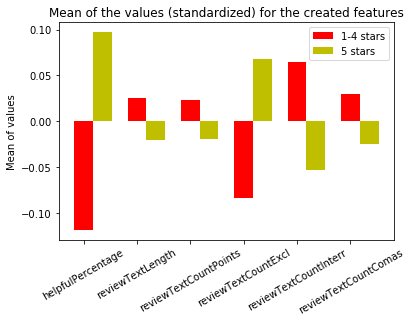

In [109]:
width = 0.35       # the width of the bars
fig, ax = plt.subplots()

ranking14 = df_created_features.as_matrix()[0]
ind = np.arange(len(ranking14))  # the x locations for the groups
rects1 = ax.bar(ind, ranking14, width, color='r')

ranking5 = df_created_features.as_matrix()[1]
rects2 = ax.bar(ind + width, ranking5, width, color='y')


# add some text for labels, title and axes ticks
ax.set_ylabel('Mean of values')
ax.set_title('Mean of the values (standardized) for the created features')
ax.set_xticks(ind)
ax.set_xticklabels(df_created_features.columns.tolist(), rotation=30)
ax.legend((rects1[0], rects2[0]), ('1-4 stars', '5 stars'))
plt.show()

The feature that we create from `helpful` seems do be very intersting. The number of exclamation (!) and interrogatoin (?) marks in the `reviewText` also seem to have a significant impact in the classification. On the other side, the length of the review and the number of point have fewer impact, but we can still see a small difference. We decided to keep all of this features for our classification models.

For the two smileys features, we can see below that the percentage of samples with a positive smiley is almost the same between the two classes. However, it is really different for negative smiley, where 5 stars ratings don't contain much. Even if the number of samples with negative smileys is low, we decided to keep this feature. For the `ALLCAPS` feature, it is the same deduction as for the `positiveSmiley` feature: we drop it too.

In [110]:
total_nbr = df2.groupby("BIN_OVERALL").size()

print("-- Positive Smiley")
print("Percentage, per class, of samples with a positive smiley")
xx = df2[df2.reviewTextPositiveSmiley == 1].groupby("BIN_OVERALL").size()
print("1-4 ==> ", xx[0] / total_nbr[0], "%")
print("5   ==> ", xx[1] / total_nbr[1], "%")

print()

print("-- Negative Smiley")
print("Percentage, per class, of samples with a negative smiley")
xx = df2[df2.reviewTextNegativeSmiley == 1].groupby("BIN_OVERALL").size()
print("1-4 ==> ", xx[0] / total_nbr[0], "%")
print("5   ==> ", xx[1] / total_nbr[1], "%")

print()

print("-- ALL CAPS word")
print("Percentage, per class, of samples contains a words written in capital letters in the reviewText feature")
xx = df2[df2.reviewTextAllCAPS == 1].groupby("BIN_OVERALL").size()
print("1-4 ==> ", xx[0] / total_nbr[0], "%")
print("5   ==> ", xx[1] / total_nbr[1], "%")

-- Positive Smiley
Percentage, per class, of samples with a positive smiley
('1-4 ==> ', 0.023037835610794481, '%')
('5   ==> ', 0.023524451939291736, '%')
()
-- Negative Smiley
Percentage, per class, of samples with a negative smiley
('1-4 ==> ', 0.0011330083087275973, '%')
('5   ==> ', 0.00053400786958965709, '%')
()
-- ALL CAPS word
Percentage, per class, of samples contains a words written in capital letters in the reviewText feature
('1-4 ==> ', 0.32843507519055137, '%')
('5   ==> ', 0.33274311410905005, '%')


In [111]:
# Let's compute the same features as we did for 'reviewText', but for the 'summary' feature this time !

# Create the new features
createTextLength(df2, "summary")
createTextPunctuationFeatures(df2, "summary")
contains_smiley(df2, "summary")
createALLCAPS(df2, "summary")


# Standardize with MinMaxScaler
summaryScalerTextLength   = StandardScaler()
summaryScalerCountPoint   = StandardScaler()
summaryScalerCountExcl    = StandardScaler()
summaryScalerCountInterr  = StandardScaler()
summaryScalerCountComas   = StandardScaler()

df2.summaryLength              =    summaryScalerTextLength.fit_transform(  df2.summaryLength.values.reshape(-1,1))
df2.summaryCountPoints         =    summaryScalerCountPoint.fit_transform( df2.summaryCountPoints.values.reshape(-1,1))
df2.summaryCountExcl           =    summaryScalerCountExcl.fit_transform(   df2.summaryCountExcl.values.reshape(-1,1))
df2.summaryCountInterr         =    summaryScalerCountInterr.fit_transform( df2.summaryCountInterr.values.reshape(-1,1))
df2.summaryCountComas          =    summaryScalerCountComas.fit_transform(  df2.summaryCountComas.values.reshape(-1,1))

As for the `reviewText feature`, this features seems interesting. It is not a surprise that the length of the summary isn't usefull, but for the others ones, we decided to keep them.

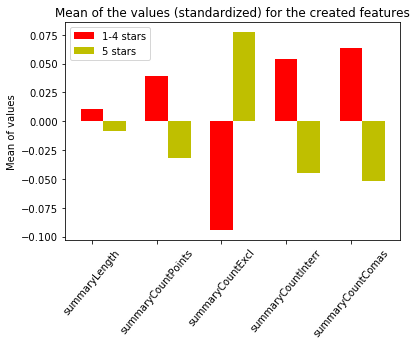

In [112]:
df_created_features = df2[["BIN_OVERALL", "summaryLength", "summaryCountPoints", "summaryCountExcl", "summaryCountInterr", "summaryCountComas"]]
df_created_features = df_created_features.groupby('BIN_OVERALL').mean()


width = 0.35       # the width of the bars
fig, ax = plt.subplots()

ranking14 = df_created_features.as_matrix()[0]
ind = np.arange(len(ranking14))  # the x locations for the groups
rects1 = ax.bar(ind, ranking14, width, color='r')

ranking5 = df_created_features.as_matrix()[1]
rects2 = ax.bar(ind + width, ranking5, width, color='y')


# add some text for labels, title and axes ticks
ax.set_ylabel('Mean of values')
ax.set_title('Mean of the values (standardized) for the created features')
ax.set_xticks(ind)
ax.set_xticklabels(df_created_features.columns.tolist(), rotation=50)
ax.legend((rects1[0], rects2[0]), ('1-4 stars', '5 stars'))
plt.show()

For the two smileys features, `summaryPositiveSmiley` and `summaryNegativeSmiley` aren't present in a lot of samples to considering it useful for something. For the feature `summaryAllCAPS`, we consider that the difference between the two classes isn't that big to keep the feature.

In [113]:
total_nbr = df2.groupby("BIN_OVERALL").size()

print("-- Positive Smiley")
print("Percentage, per class, of samples with a positive smiley")
xx = df2[df2.summaryPositiveSmiley == 1].groupby("BIN_OVERALL").size()
print("1-4 ==> ", xx[0] / total_nbr[0], "%")
print("5   ==> ", xx[1] / total_nbr[1], "%")

print()

print("-- Negative Smiley")
print("Percentage, per class, of samples with a negative smiley")
xx = df2[df2.summaryNegativeSmiley == 1].groupby("BIN_OVERALL").size()
print("1-4 ==> ", xx[0] / total_nbr[0], "%")
print("5   ==> ", 0, "%")

print()

print("-- ALL CAPS word")
print("Percentage, per class, of samples contains a words written in capital letters in the reviewText feature")
xx = df2[df2.summaryAllCAPS == 1].groupby("BIN_OVERALL").size()
print("1-4 ==> ", xx[0] / total_nbr[0], "%")
print("5   ==> ", xx[1] / total_nbr[1], "%")

-- Positive Smiley
Percentage, per class, of samples with a positive smiley
('1-4 ==> ', 0.00044633660646844743, '%')
('5   ==> ', 0.00084317032040472171, '%')
()
-- Negative Smiley
Percentage, per class, of samples with a negative smiley
('1-4 ==> ', 0.00034333585112957497, '%')
('5   ==> ', 0, '%')
()
-- ALL CAPS word
Percentage, per class, of samples contains a words written in capital letters in the reviewText feature
('1-4 ==> ', 0.078898578589576329, '%')
('5   ==> ', 0.10871275997751546, '%')


In [114]:
# Merge all features into a single dataframe
X2 = hstack((x_reviewText, x_summary))
featuresToUse = ["helpfulPercentage", "reviewTextLength", "reviewTextCountPoints", "reviewTextCountExcl", "reviewTextCountInterr", "reviewTextCountComas", "reviewTextNegativeSmiley", \
                "summaryCountPoints", "summaryCountExcl", "summaryCountInterr", "summaryCountComas", "positiveRatio", "positiveRatioSummary"]
for c in featuresToUse:
    X2 = hstack((X2,(df2[c])[:,None]))

In [115]:
y = df2.BIN_OVERALL

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=seed)

# Train
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

# Test
print("X_test:  ", X_test.shape)
print("y_test:  ", y_test.shape)

('X_train: ', (51764, 26525))
('y_train: ', (51764,))
('X_test:  ', (12942, 26525))
('y_test:  ', (12942,))


> **Some notes about the preprocessing for steps 2 & 3**
>
> * We decide to not merge the features 'reviewText' and 'summary'. They are both two textual features that we transform into numerical values and we use the same piple, so one could argue that they could have been combined and speed up the computational time of the models. Even if this last argument is interesting, we think that the information stored in the 'summary' feature is very important. To sum up, some key words are specific to the feature `summary`, and merging them with the words in the 'reviewText' will result in a loss of information. So we decided to use two separate pipelines for this two different features.
>
>
> * The data is skewed. For step 2, the difference exists but is not significant. But for step 3, where we will build a classifier with 5 classes, skewed data can have a large impact. We think about it and decided to... do nothing. As we have seen from the data in step 1, the probability for a review to be a 5 stars is much higher that to be a 1 start product. Therefore, we hope that the unseen data follows the same path.
>
>
> * Coming back to the 'reviewerID' feature, we could also have created another new feature for the steps 2 & 3 in order to find out if an user is a "troll" or not. If that user only rates negatively. Basicly, if he is a good, a bad or a random worker. We did not take into account the reviewer / the user. To take it into account, we could have analyzed the impact of adding the rating mean of the user as a new feature. Then standardize it, so new users will be assigned with a mean of 0. Using the variance would also help flagging random workers.

## <a name="models2"> </a> Models

### Baseline model

In [130]:
baselineModel = DummyClassifier(random_state=seed)
baselineModel.fit(X_train,y_train)
y_pred = baselineModel.predict(X_test)

print_precision(y_test, y_pred)

('Precision mean: ', 0.50169982832125326)


In [131]:
baseline_precision = 0.501699828321

We have two classes, so we actually expect the precision to be $\approx\dfrac{1}{2}$.

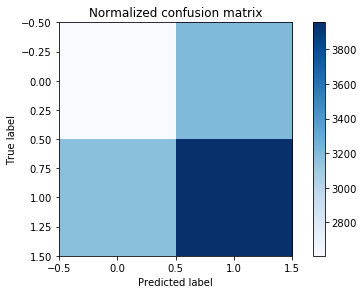

In [132]:
print_confusion_matrix(y_test, y_pred, 2)

### Support Vector Model: Linear Support Vector Classification

In [133]:
# setup pipeline
estimators = []
estimators.append(('svm_clf', LinearSVC()))
pipe = Pipeline(estimators)

# tuning requsted parameter
tuned_parameters = [{'svm_clf__C': np.logspace(-5,15,11,base=2.0)}]
clf = GridSearchCV(pipe, tuned_parameters, cv=5, scoring='accuracy')

# Speed up computation: with only a subset of the training data for Grid search
subset_size = 5000
clf.fit(X_train[:subset_size],y_train[:subset_size])
clf.best_params_

{'svm_clf__C': 0.125}

In [134]:
# bect C value resulting from GridSearch
best_C = 0.125

In [135]:
svc = LinearSVC(C=best_C)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print_precision(y_test, y_pred)

('Precision mean: ', 0.77924003996503055)


In [136]:
svc_precision = 0.779240039965

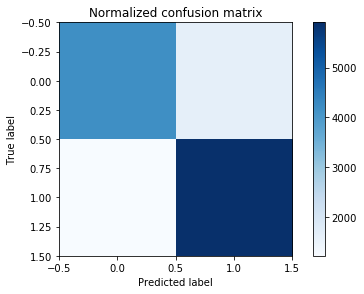

In [137]:
print_confusion_matrix(y_test, y_pred, 2)

### Linear Model:  Stochastic Gradient Descent

In [138]:
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.001, 0.0001, 0.00001, 0.000001]
}
cv = KFold(n_splits=10, random_state=seed)
sgd = GridSearchCV(SGDClassifier(loss="hinge", random_state=seed), parameters,
     scoring="accuracy", cv=cv)

runGridSearch = False
if (runGridSearch):
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.001, random_state=seed)
    X_train_s1, X_test_s1, y_train_s1, y_test_s1 = train_test_split(X_train_s, y_train_s, test_size=0.2, random_state=seed)
    sgd.fit(X_train_s1, y_train_s1)
    print("Best params:", sgd.best_estimator_.get_params())
else:
    # Copy/Paste from the results of the 'if' block
    print("Best params: {'alpha': 0.0001, 'average': False, 'class_weight': None, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True,\
          'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_iter': 5, 'n_jobs': 1, 'penalty': 'elasticnet', 'power_t': 0.5, 'random_state': 2017, 'shuffle': True, 'verbose': 0, 'warm_start': False}")

Best params: {'alpha': 0.0001, 'average': False, 'class_weight': None, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True,          'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_iter': 5, 'n_jobs': 1, 'penalty': 'elasticnet', 'power_t': 0.5, 'random_state': 2017, 'shuffle': True, 'verbose': 0, 'warm_start': False}


In [139]:
# Build the SGDClassifier with the best params return by grid search
sgd = SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15, learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1, penalty='elasticnet',
                    power_t= 0.5, random_state=2017, shuffle=True, verbose=0, warm_start=False)

# Predict testing data
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
print_precision(y_test, y_pred)

('Precision mean: ', 0.77359372856162056)


In [140]:
SGD_precision = 0.773593728562

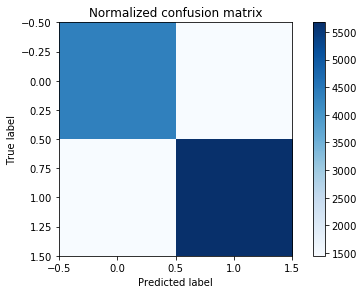

In [141]:
print_confusion_matrix(y_test, y_pred, 2)

### Similarity-based model: KNN Classifier

In [142]:
estimators = []
estimators.append(('knn_clf', KNeighborsClassifier()))
knn_clf_pipe = Pipeline(estimators)
knn_clf_pipe.set_params(knn_clf__algorithm='brute')
knn_clf_pipe.set_params(knn_clf__weights='distance')

# create a grid search over n_neighbors values
# We decided to test from a large variety of neighbors possible. To speed up the computation time, we didn't test all possibilities, but use a step between each number
parameters = {
        'knn_clf__n_neighbors' : range(1,151,10)
}
estimator_knnclf = GridSearchCV(knn_clf_pipe, parameters, cv=5)

run = False
if run:
    # With our machines, we had several memory errors. Therefore we decide to use less data in order to have some results
    subset_size = 10000
    # evaluate the grid search and print best regressor
    estimator_knnclf.fit(X_train[:subset_size], y_train[:subset_size])
    print(estimator_knnclf.best_estimator_)
else:
    # Copy/Paste from the results of the 'if' block
    print("Pipeline(steps=[('knn_clf', KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',\
           metric_params=None, n_jobs=1, n_neighbors=71, p=2,\
           weights='uniform'))])")

Pipeline(steps=[('knn_clf', KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',           metric_params=None, n_jobs=1, n_neighbors=71, p=2,           weights='uniform'))])


In [143]:
# best number of neighbors obtained using GridSearchCV
best_clf_tree_neighbors = 71

In [144]:
# fix the number of neighbors to the best value
knn_clf_pipe.set_params(knn_clf__n_neighbors=best_clf_tree_neighbors)

# fit the model to the training set
knn_clf_pipe.fit(X_train, y_train)

# Need to use a subset to avoid memorry_errors !
subset_size = 2000
y_pred = knn_clf_pipe.predict(X_test[:subset_size])
print_precision(y_test[:subset_size], y_pred)

('Precision mean: ', 0.63337657443581974)


In [145]:
knn_precision = 0.633376574436

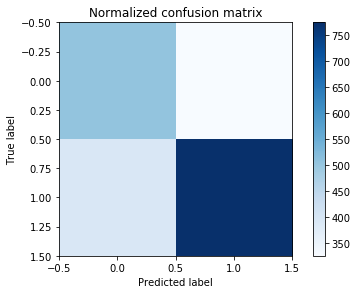

In [147]:
print_confusion_matrix(y_test[:subset_size], y_pred, 2)

### Information Based model: Random Forest Classifier

In [148]:
tuned_parameters = {
    'n_estimators': range(1,801,100),
    'max_depth': range(1,101,20)
    }

rf_clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, scoring='accuracy')

run = False
if run:
    # As for before, we need to use less data to avoid 'memory_errors'
    subset_size = 1000
    rf_clf.fit(X_train[:subset_size],y_train[:subset_size])
    print(rf_clf.best_params_)
else:
    print("{'max_depth': 41, 'n_estimators': 501}")

{'max_depth': 41, 'n_estimators': 501}


In [149]:
tuned_parameters = {
    'n_estimators': range(492,511,5),
    'max_depth': range(32,51,3)
    }

rf_clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, scoring='accuracy')

run = False
if run:
    # As for before, we need to use less data to avoid 'memory_errors'
    subset_size = 1000
    rf_clf.fit(X_train[:subset_size],y_train[:subset_size])
    print(rf_clf.best_params_)
else:
    print("{'max_depth': 32, 'n_estimators': 507}")

{'max_depth': 32, 'n_estimators': 507}


In [150]:
best_n_estimators = 507
best_clf_tree_depth = 32

In [151]:
rf_clf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_clf_tree_depth)

# As previously, we need to use less data to avoid 'memory_errors' and speed up the all computation
subset_size = 10000
rf_clf.fit(X_train[:subset_size],y_train[:subset_size])

y_pred = rf_clf.predict(X_test)
print_precision(y_test, y_pred)

('Precision mean: ', 0.75841901352015095)


In [152]:
randomForest_precision = 0.761861106092

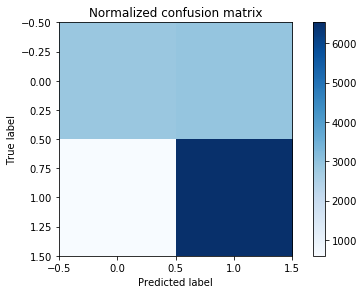

In [153]:
print_confusion_matrix(y_test, y_pred, 2)

## <a name="modelscomparison2"> </a>Models comparison

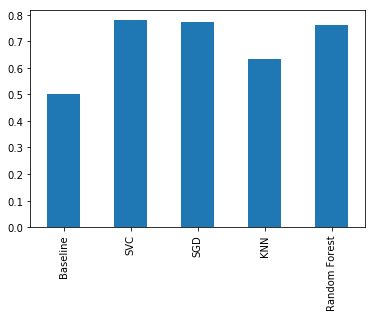

In [154]:
models_precision = [baseline_precision, svc_precision, SGD_precision, knn_precision, randomForest_precision]
models = ["Baseline", "SVC", "SGD", "KNN", "Random Forest"]

models_df = pd.DataFrame(models_precision, models)
models_df[0].plot(kind='bar')
plt.show()

In [155]:
models_precision

[0.501699828321,
 0.779240039965,
 0.773593728562,
 0.633376574436,
 0.761861106092]

As for step 1, we have the two linear models among the tree models that perform best. We can also note that the KNN model has 'reduced' its difference with the others. But as for step 1, the two linear models are performing better and the **SVC model** seems to be the best fit to predict the unseen data (difference of 0.0056 !)

## <a name="unseen2"> </a>Prediction of the unseen data

In [156]:
# We will apply the same modification as for the preprocessing step for this new dataset

!gunzip -c amazon_step1_unseen.csv.gz > amazon_step1_unseen.csv
df2_unseen = pd.read_csv("amazon_step2_unseen.csv")

df2_unseen.sample(5)

,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,summary,unixReviewTime,reviewTime,label
3116,3116,A1UCO1WWVZBZFB,B00C5CTW9G,Ty,"[0, 0]","Look, nothing can capture the feeling of seein...",Happy to be in the Stomp,1372291200,"06 27, 2013",?
1927,1927,A1P4J7OWPC305Z,B00002S5DF,"""big_talka""","[0, 1]",wat is up wit all of ull hating on biggie caus...,this aint ready to die but this aint no 3 star...,1058313600,"07 16, 2003",?
11096,11096,A3E71IZE9IK9WM,B0090OPBTC,Justin Clash,"[0, 0]",I really don't ever purchase many albums let a...,Best album in a long time,1392854400,"02 20, 2014",?
3618,3618,A2708RDLWPPDOM,B0048IOHM2,Proud Mommy,"[0, 0]",Taylor Swift might not be the best vocalist ar...,Cute Song,1288483200,"10 31, 2010",?
14538,14538,A1RNGCMRM9Q2MT,B000089CJI,green giggie,"[0, 1]",I overheard one of my friends talking about th...,I'm thinking it's a sign...,1134604800,"12 15, 2005",?


In [157]:
# Verifiy if this data as null values
df2_unseen.isnull().sum()

Unnamed: 0         0
reviewerID         0
asin               0
reviewerName      44
helpful            0
reviewText         0
summary            0
unixReviewTime     0
reviewTime         0
label              0
dtype: int64

In [158]:
# Create the new features
createHelpfulPercentage(df2_unseen)
createTextLength(df2_unseen, "reviewText")
createTextPunctuationFeatures(df2_unseen, "reviewText")
contains_smiley(df2_unseen, "reviewText")
createALLCAPS(df2_unseen, "reviewText")
createTextLength(df2_unseen, "summary")
createTextPunctuationFeatures(df2_unseen, "summary")
contains_smiley(df2_unseen, "summary")
createALLCAPS(df2_unseen, "summary")
wordSentimentRatio(df2_unseen)


# Standardize with MinMaxScaler
df2_unseen.helpfulPercentage          =    scalerHelpful.transform(     df2_unseen.helpfulPercentage.values.reshape(-1,1))
df2_unseen.reviewTextLength           =    scalerTextLength.transform(  df2_unseen.reviewTextLength.values.reshape(-1,1))
df2_unseen.reviewTextCountPoints      =    scalerCountPoints.transform( df2_unseen.reviewTextCountPoints.values.reshape(-1,1))
df2_unseen.reviewTextCountExcl        =    scalerCountExcl.transform(   df2_unseen.reviewTextCountExcl.values.reshape(-1,1))
df2_unseen.reviewTextCountInterr      =    scalerCountInterr.transform( df2_unseen.reviewTextCountInterr.values.reshape(-1,1))
df2_unseen.reviewTextCountComas       =    scalerCountComas.transform(  df2_unseen.reviewTextCountComas.values.reshape(-1,1))
df2_unseen.summaryLength              =    summaryScalerTextLength.transform(  df2_unseen.summaryLength.values.reshape(-1,1))
df2_unseen.summaryCountPoints         =    summaryScalerCountPoint.transform( df2_unseen.summaryCountPoints.values.reshape(-1,1))
df2_unseen.summaryCountExcl           =    summaryScalerCountExcl.transform(   df2_unseen.summaryCountExcl.values.reshape(-1,1))
df2_unseen.summaryCountInterr         =    summaryScalerCountInterr.transform( df2_unseen.summaryCountInterr.values.reshape(-1,1))
df2_unseen.summaryCountComas          =    summaryScalerCountComas.transform(  df2_unseen.summaryCountComas.values.reshape(-1,1))

# TF-IDF for 'reviewText'
pipe_modified.fit(df2.reviewText)
x_reviewText = pipe_modified.transform(df2_unseen.reviewText)

# TF-IDF for 'summary'
pipe_modified.fit(df2.summary)
x_summary = pipe_modified.transform(df2_unseen.summary)

# Merge all features into a single dataframe
X_unseen = hstack((x_reviewText, x_summary))
featuresToUse = ["helpfulPercentage", "reviewTextLength", "reviewTextCountPoints", "reviewTextCountExcl", "reviewTextCountInterr", "reviewTextCountComas", "reviewTextNegativeSmiley", \
                "summaryCountPoints", "summaryCountExcl", "summaryCountInterr", "summaryCountComas", "positiveRatio", "positiveRatioSummary"]
for c in featuresToUse:
    X_unseen = hstack((X_unseen,(df2_unseen[c])[:,None]))

In [159]:
# SVC Classifier gives use the best prediction accuracy, we use it 
svc = LinearSVC(C=best_C)
svc.fit(X2, y)

y_unseen_pred = svc.predict(X_unseen)

In [160]:
# export the prediction into a file named "pred2.txt"
file = open('pred2.txt', 'w')
for item in y_unseen_pred:
  file.write("%s\n" % item)

# <a name="step3"> </a>Step 3

> Predict the actual number of stars, based on the reviewText field. Again, the dataset for this step is filtered down to the Digital_Music category. Construct the problem as a multiclass classification (5 categories labeled from 1 to 5).
>
> `f(reviewText) -> overall`

## <a name="preprocessing3"> </a> Preprocessing

In [161]:
# We use exactly the same preprocessing as for `step 2`
df3 = df2.copy(deep=True)
df3.sample(5)

,overall,reviewText,summary,helpfulPercentage,reviewTextLength,reviewTextCountPoints,reviewTextCountExcl,reviewTextCountInterr,reviewTextCountComas,reviewTextPositiveSmiley,...,positiveRatio,positiveRatioSummary,summaryLength,summaryCountPoints,summaryCountExcl,summaryCountInterr,summaryCountComas,summaryPositiveSmiley,summaryNegativeSmiley,summaryAllCAPS
34328,4,WHo says the West can't flow? This album prove...,Finna Show You How The West Coast Rocks!!!,-1.224579,-0.532442,-0.334815,0.026761,0.621531,-0.513609,0,...,1.0,1.0,0.842191,-0.343490,2.141653,-0.144688,-0.316271,0,0,False
32534,5,This CD is like a freakin' brother to me. It'...,I SWEAR BY THIS CD,-0.634354,-0.761575,-0.488985,-0.320319,-0.327919,-0.773790,0,...,1.0,1.0,-0.633050,-0.343490,-0.242413,-0.144688,-0.316271,0,0,True
52397,5,Newly newly newly. You are such a free spirit ...,looser!,-1.224579,-0.898506,-0.797326,0.373840,-0.327919,-0.860517,0,...,1.0,1.0,-1.309203,-0.343490,0.552276,-0.144688,-0.316271,0,0,False
63521,4,The Yeah Yeah Yeahs much like fellow New Yorke...,"YEAH YEAH YEAHS DELIVER AGAIN WITH ""MOSQUITO""",0.428052,1.087916,-0.103560,1.068000,-0.327919,-0.687063,0,...,1.0,1.0,1.026596,-0.343490,-0.242413,-0.144688,-0.316271,0,0,True
28332,4,I would have to say this doesn't deserve a ful...,They're pretty good...,-0.044128,-0.109780,1.052718,0.026761,-0.327919,0.440389,0,...,1.0,1.0,-0.387177,1.605576,-0.242413,-0.144688,-0.316271,0,0,False


In [162]:
# The output for part 2 isn't applicable here
df3 = df3.drop(['BIN_OVERALL'], axis=1)

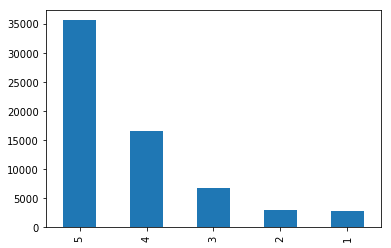

In [163]:
# Confirmation of what we wrote earlier: data is skewed
df3.overall.value_counts().plot(kind='bar')
plt.show()

In [164]:
df_created_features = df3.groupby('overall').mean()
df_created_features = df_created_features.drop(['reviewTextPositiveSmiley', 'reviewTextNegativeSmiley', 'reviewTextAllCAPS', 'summaryPositiveSmiley', 'summaryNegativeSmiley', 'summaryAllCAPS', ], axis=1)
df_created_features

,helpfulPercentage,reviewTextLength,reviewTextCountPoints,reviewTextCountExcl,reviewTextCountInterr,reviewTextCountComas,positiveRatio,positiveRatioSummary,summaryLength,summaryCountPoints,summaryCountExcl,summaryCountInterr,summaryCountComas
overall,,,,,,,,,,,,,
1,-0.335824,-0.376946,-0.246240,0.134205,0.394289,-0.329403,0.988695,0.995999,-0.111395,0.091576,0.086169,0.370742,-0.022576
2,-0.340399,-0.128550,-0.047065,-0.081976,0.228819,-0.125382,0.985658,0.994740,-0.069318,0.101795,-0.128622,0.278558,0.053857
3,-0.247434,0.051797,0.053358,-0.159637,0.078209,0.057405,0.990815,0.992453,0.027809,0.072123,-0.158016,0.061875,0.137905
4,0.011647,0.110114,0.068740,-0.089100,-0.026594,0.107222,0.994704,0.996452,0.038150,0.005321,-0.092279,-0.042961,0.049141
5,0.096940,-0.020616,-0.018831,0.068278,-0.052850,-0.024339,0.996739,0.999250,-0.008435,-0.032030,0.077160,-0.044488,-0.051937


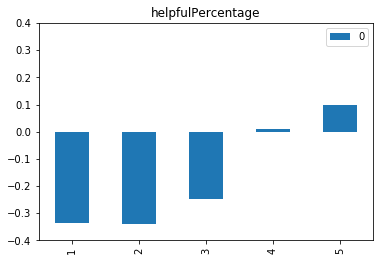

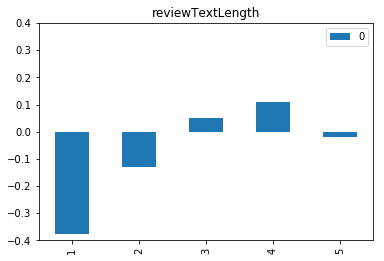

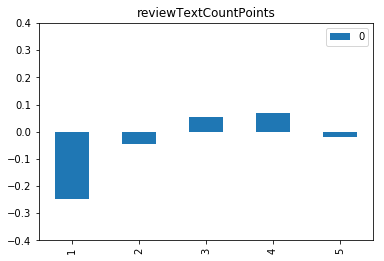

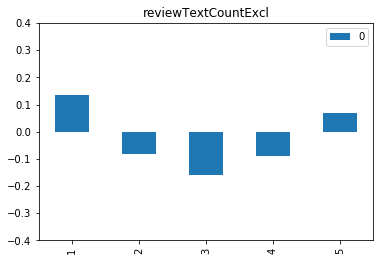

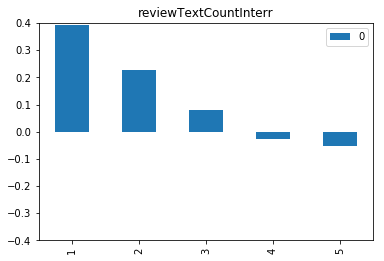

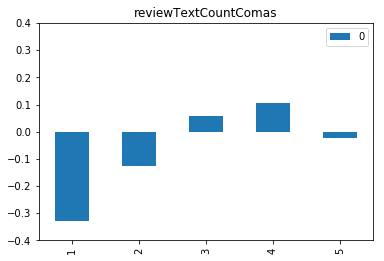

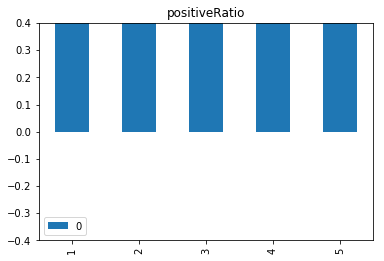

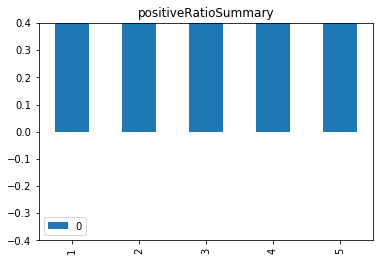

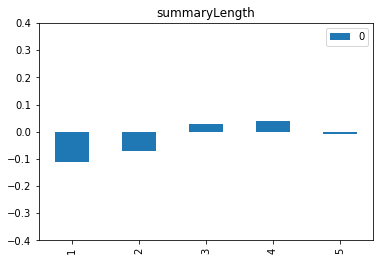

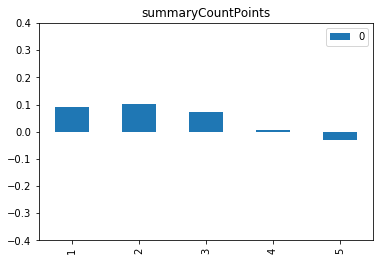

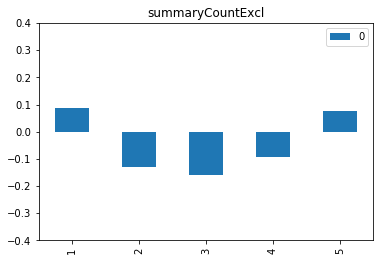

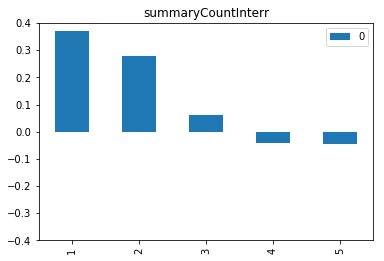

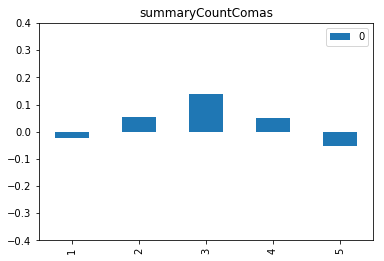

In [165]:
for x in df_created_features:
    mean_values = df_created_features[x].values
    overall = ["1", "2", "3", "4", "5"]
    
    mvalues_df = pd.DataFrame(mean_values, overall)
    mvalues_df.plot(kind='bar')
    
    plt.title(x)
    plt.ylim([-0.4, 0.4])
    plt.show()

We decide to keep all features created !

In [166]:
total_nbr = df3.groupby("overall").size()

print("-- Positive Smiley")
print("Percentage, per class, of samples with a positive smiley")
xx = df3[df3.reviewTextPositiveSmiley == 1].groupby("overall").size()
for i in range(1,6):
    if i not in xx:
        xx[i] = 0
print("1 ==> ", xx[1] / total_nbr[1], "%")
print("2 ==> ", xx[2] / total_nbr[2], "%")
print("3 ==> ", xx[3] / total_nbr[3], "%")
print("4 ==> ", xx[4] / total_nbr[4], "%")
print("5 ==> ", xx[5] / total_nbr[5], "%")

print()

print("-- Negative Smiley")
print("Percentage, per class, of samples with a negative smiley")
xx = df3[df3.reviewTextNegativeSmiley == 1].groupby("overall").size()
for i in range(1,6):
    if i not in xx:
        xx[i] = 0
print("1 ==> ", xx[1] / total_nbr[1], "%")
print("2 ==> ", xx[2] / total_nbr[2], "%")
print("3 ==> ", xx[3] / total_nbr[3], "%")
print("4 ==> ", xx[4] / total_nbr[4], "%")
print("5 ==> ", xx[5] / total_nbr[5], "%")

print()

print("-- ALL CAPS word")
print("Percentage, per class, of samples contains a words written in capital letters in the reviewText feature")
xx = df3[df3.reviewTextAllCAPS == 1].groupby("overall").size()
for i in range(1,6):
    if i not in xx:
        xx[i] = 0
print("1 ==> ", xx[1] / total_nbr[1], "%")
print("2 ==> ", xx[2] / total_nbr[2], "%")
print("3 ==> ", xx[3] / total_nbr[3], "%")
print("4 ==> ", xx[4] / total_nbr[4], "%")
print("5 ==> ", xx[5] / total_nbr[5], "%")

-- Positive Smiley
Percentage, per class, of samples with a positive smiley
('1 ==> ', 0.0096739519885345755, '%')
('2 ==> ', 0.013621262458471761, '%')
('3 ==> ', 0.021947267638827515, '%')
('4 ==> ', 0.027455249153362362, '%')
('5 ==> ', 0.023524451939291736, '%')
()
-- Negative Smiley
Percentage, per class, of samples with a negative smiley
('1 ==> ', 0.0032246506628448583, '%')
('2 ==> ', 0.0019933554817275745, '%')
('3 ==> ', 0.0010310796877301518, '%')
('4 ==> ', 0.00066521528785679724, '%')
('5 ==> ', 0.00053400786958965709, '%')
()
-- ALL CAPS word
Percentage, per class, of samples contains a words written in capital letters in the reviewText feature
('1 ==> ', 0.36725188104621997, '%')
('2 ==> ', 0.33621262458471762, '%')
('3 ==> ', 0.31447930475769625, '%')
('4 ==> ', 0.32619738751814226, '%')
('5 ==> ', 0.33274311410905005, '%')


In [167]:
total_nbr = df3.groupby("overall").size()

print("-- Positive Smiley")
print("Percentage, per class, of samples with a positive smiley")
xx = df3[df3.summaryPositiveSmiley == 1].groupby("overall").size()
for i in range(1,6):
    if i not in xx:
        xx[i] = 0
print("1 ==> ", xx[1] / total_nbr[1], "%")
print("2 ==> ", xx[2] / total_nbr[2], "%")
print("3 ==> ", xx[3] / total_nbr[3], "%")
print("4 ==> ", xx[4] / total_nbr[4], "%")
print("5 ==> ", xx[5] / total_nbr[5], "%")

print()

print("-- Negative Smiley")
print("Percentage, per class, of samples with a negative smiley")
xx = df3[df3.summaryNegativeSmiley == 1].groupby("overall").size()
for i in range(1,6):
    if i not in xx:
        xx[i] = 0
print("1 ==> ", xx[1] / total_nbr[1], "%")
print("2 ==> ", xx[2] / total_nbr[2], "%")
print("3 ==> ", xx[3] / total_nbr[3], "%")
print("4 ==> ", xx[4] / total_nbr[4], "%")
print("5 ==> ", xx[5] / total_nbr[5], "%")

print()

print("-- ALL CAPS word")
print("Percentage, per class, of samples contains a words written in capital letters in the reviewText feature")
xx = df3[df3.summaryAllCAPS == 1].groupby("overall").size()
for i in range(1,6):
    if i not in xx:
        xx[i] = 0
print("1 ==> ", xx[1] / total_nbr[1], "%")
print("2 ==> ", xx[2] / total_nbr[2], "%")
print("3 ==> ", xx[3] / total_nbr[3], "%")
print("4 ==> ", xx[4] / total_nbr[4], "%")
print("5 ==> ", xx[5] / total_nbr[5], "%")

-- Positive Smiley
Percentage, per class, of samples with a positive smiley
('1 ==> ', 0.0, '%')
('2 ==> ', 0.00033222591362126248, '%')
('3 ==> ', 0.00029459419649432907, '%')
('4 ==> ', 0.00060474117077890664, '%')
('5 ==> ', 0.00084317032040472171, '%')
()
-- Negative Smiley
Percentage, per class, of samples with a negative smiley
('1 ==> ', 0.00035829451809387314, '%')
('2 ==> ', 0.00099667774086378727, '%')
('3 ==> ', 0.00058918839298865815, '%')
('4 ==> ', 0.00012094823415578132, '%')
('5 ==> ', 0.0, '%')
()
-- ALL CAPS word
Percentage, per class, of samples contains a words written in capital letters in the reviewText feature
('1 ==> ', 0.14582586886420637, '%')
('2 ==> ', 0.080066445182724252, '%')
('3 ==> ', 0.070555310060391813, '%')
('4 ==> ', 0.070815191098209967, '%')
('5 ==> ', 0.10871275997751546, '%')


In [168]:
# TF-IDF for 'reviewText'
pipe_modified.fit(df3.reviewText)
x_reviewText = pipe_modified.transform(df3.reviewText)

# TF-IDF for 'summary'
pipe_modified.fit(df3.summary)
x_summary = pipe_modified.transform(df3.summary)

In [169]:
# Merge all features into a single dataframe
X3 = hstack((x_reviewText, x_summary))

In [170]:
featuresToUse = ["helpfulPercentage", "reviewTextLength", "reviewTextCountPoints", "reviewTextCountExcl", "reviewTextCountInterr", "reviewTextCountComas", "reviewTextPositiveSmiley", "reviewTextNegativeSmiley", "reviewTextAllCAPS", \
                "summaryCountPoints", "summaryCountExcl", "summaryCountInterr", "summaryCountComas", "summaryPositiveSmiley", "summaryNegativeSmiley", "summaryAllCAPS"]
for c in featuresToUse:
    X3 = hstack((X3,(df3[c])[:,None]))

In [171]:
y = df3.overall

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=seed)

# Train
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

# Test
print("X_test:  ", X_test.shape)
print("y_test:  ", y_test.shape)

('X_train: ', (51764, 26528))
('y_train: ', (51764,))
('X_test:  ', (12942, 26528))
('y_test:  ', (12942,))


## <a name="models3"> </a> Models

### Baseline model

In [173]:
baselineModel = DummyClassifier(random_state=seed)
baselineModel.fit(X_train,y_train)
y_pred = baselineModel.predict(X_test)

print_precision(y_test, y_pred)

('Precision mean: ', 0.20268073213601814)


In [174]:
baseline_precision = 0.202680732136

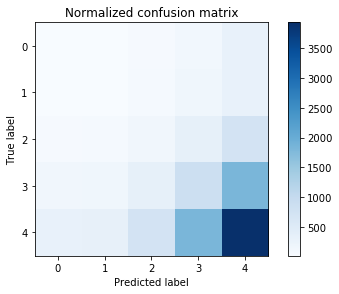

In [175]:
print_confusion_matrix(y_test, y_pred, 5)

### Support Vector Model: Linear Support Vector Classification

In [176]:
# setup pipeline
estimators = []
estimators.append(('svm_clf', LinearSVC()))
pipe = Pipeline(estimators)

# tuning requsted parameter
tuned_parameters = [{'svm_clf__C': np.logspace(-5,15,11,base=2.0)}]
clf = GridSearchCV(pipe, tuned_parameters, cv=5, scoring='accuracy')

# Speed up computation: with only a subset of the training data for Grid search
subset_size = 2000
clf.fit(X_train[:subset_size],y_train[:subset_size])
clf.best_params_

{'svm_clf__C': 0.125}

In [177]:
# bect C value resulting from GridSearch
best_C = 0.125

In [178]:
svc = LinearSVC(C=best_C)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print_precision(y_test, y_pred)

('Precision mean: ', 0.57010791838035624)


In [179]:
svc_precision = 0.569999522747

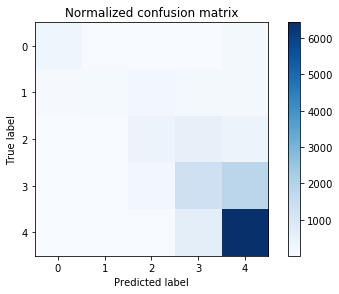

In [180]:
print_confusion_matrix(y_test, y_pred, 5)

### Linear Model:  Stochastic Gradient Descent

In [181]:
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.001, 0.0001, 0.00001, 0.000001]
}
cv = KFold(n_splits=10, random_state=seed)
sgd = GridSearchCV(SGDClassifier(loss="hinge", random_state=seed), parameters,
     scoring="accuracy", cv=cv)

# Takes approximately 15 minutes to run with our machines
runGridSearch = False
if (runGridSearch):
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.001, random_state=seed)
    X_train_s1, X_test_s1, y_train_s1, y_test_s1 = train_test_split(X_train_s, y_train_s, test_size=0.2, random_state=seed)
    sgd.fit(X_train_s1, y_train_s1)
    print("Best params:", sgd.best_estimator_.get_params())
else:
    # Copy/Paste from the results of the 'if' block
    print("Best params: {'alpha': 0.0001,, 'average': False, 'class_weight': None, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, \
          'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_iter': 5, 'n_jobs': 1, 'penalty': 'l1', 'power_t': 0.5, 'random_state': 2017, 'shuffle': True, 'verbose': 0, 'warm_start': False}")

Best params: {'alpha': 0.0001,, 'average': False, 'class_weight': None, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True,           'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_iter': 5, 'n_jobs': 1, 'penalty': 'l1', 'power_t': 0.5, 'random_state': 2017, 'shuffle': True, 'verbose': 0, 'warm_start': False}


In [182]:
# Build the SGDClassifier with the best params return by grid search
sgd = SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15, learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1, penalty='l1', power_t=0.5, random_state=2017, shuffle= True, verbose=0, warm_start=False)

# Predict testing data
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
print_precision(y_test, y_pred)

('Precision mean: ', 0.50937493808932133)


In [183]:
SGD_precision = 0.509374938089

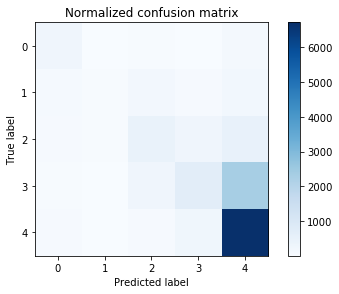

In [184]:
print_confusion_matrix(y_test, y_pred, 5)

### Similarity-based model: KNN Classifier

In [185]:
estimators = []
estimators.append(('knn_clf', KNeighborsClassifier()))
knn_clf_pipe = Pipeline(estimators)
knn_clf_pipe.set_params(knn_clf__algorithm='brute')
knn_clf_pipe.set_params(knn_clf__weights='distance')

# create a grid search over n_neighbors values
# We decided to test from a large variety of neighbors possible. To speed up the computation time, we didn't test all possibilities, but use a step between each number
parameters = {
        'knn_clf__n_neighbors' : range(1,151,10)
}
estimator_knnclf = GridSearchCV(knn_clf_pipe, parameters, cv=5)

run = False
if run:
    # With our machines, we had several memory errors. Therefore we decide to use less data in order to have some results
    subset_size = 10000
    # evaluate the grid search and print best regressor
    estimator_knnclf.fit(X_train[:subset_size], y_train[:subset_size])
    print(estimator_knnclf.best_estimator_)
else:
    # Copy/Paste from the results of the 'if' block
    print("Pipeline(steps=[('knn_clf', KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',\
           metric_params=None, n_jobs=1, n_neighbors=91, p=2,\
           weights='uniform'))])")

Pipeline(steps=[('knn_clf', KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',           metric_params=None, n_jobs=1, n_neighbors=91, p=2,           weights='uniform'))])


In [186]:
# best number of neighbors obtained using GridSearchCV
best_clf_neighbors = 91

In [187]:
# fix the number of neighbors to the best value
knn_clf_pipe.set_params(knn_clf__n_neighbors=best_clf_neighbors)

# fit the model to the training set
knn_clf_pipe.fit(X_train, y_train)

subset_size = 5000
y_pred = knn_clf_pipe.predict(X_test[:subset_size])
print_precision(y_test[:subset_size], y_pred)

('Precision mean: ', 0.4409833488367868)


In [188]:
knn_precision = 0.440983348837

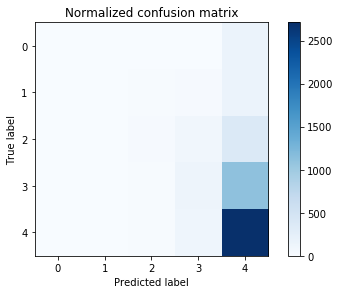

In [191]:
print_confusion_matrix(y_test[:subset_size], y_pred, 5)

### Information Based model: Random Forest Classifier

In [192]:
tuned_parameters = {
    'n_estimators': range(1,501,100),
    'max_depth': range(44,104,10)
    }

rf_clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, scoring='accuracy')

run = False
if run:
    # As for before, we need to use less data to avoid 'memory_errors'
    subset_size = 1000
    rf_clf.fit(X_train[:subset_size],y_train[:subset_size])
    print(rf_clf.best_params_)
else:
    print("{'max_depth': 74, 'n_estimators': 101}")

{'max_depth': 74, 'n_estimators': 101}


In [193]:
tuned_parameters = {
    'n_estimators': range(90,111,2),
    'max_depth': range(60,90,2)
    }

rf_clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, scoring='accuracy')

run = False
if run:
    # As for before, we need to use less data to avoid 'memory_errors'
    subset_size = 1000
    rf_clf.fit(X_train[:subset_size],y_train[:subset_size])
    print(rf_clf.best_params_)
else:
    print("{'max_depth': 72, 'n_estimators': 106}")

{'max_depth': 72, 'n_estimators': 106}


In [194]:
best_clf_tree_depth = 72
best_n_estimators = 106

In [195]:
rf_clf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_clf_tree_depth)

# As for before, we need to use less data to avoid 'memory_errors' and speed up the all computation
rf_clf.fit(X_train,y_train)

y_pred = rf_clf.predict(X_test)
print_precision(y_test, y_pred)

('Precision mean: ', 0.57103651860461202)


/root/miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [196]:
randomForest_precision = 0.510858219221

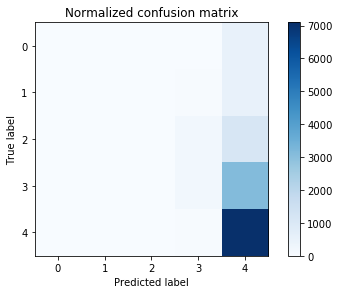

In [197]:
print_confusion_matrix(y_test, y_pred, 5)

## <a name="modelscomparison3"> </a> Model comparison and best model
We rank our models by the accuracy it achieved with the test data.

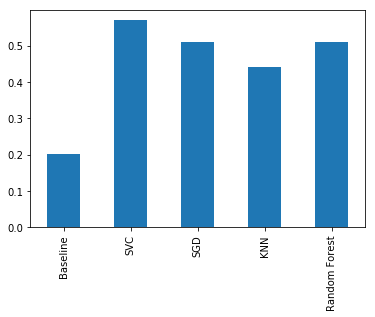

In [198]:
models_precision = [baseline_precision, svc_precision, SGD_precision, knn_precision, randomForest_precision]
models = ["Baseline", "SVC", "SGD", "KNN", "Random Forest"]

models_df = pd.DataFrame(models_precision, models)
models_df[0].plot(kind='bar')
plt.show()

In [199]:
models_precision

[0.202680732136,
 0.569999522747,
 0.509374938089,
 0.440983348837,
 0.510858219221]

We observe the same results as before, the two linear models perform the best, with a slightly better accuracy score for the **SVC model**. Note that for this step 3, the scores are much lower compare to the two others steps.

## <a name="unseen3"> </a> Prediction of the unseen data

In [ ]:
# We will apply the same modification as for the preprocessing step for this new dataset

!gunzip -c amazon_step1_unseen.csv.gz > amazon_step1_unseen.csv
df3_unseen = pd.read_csv("amazon_step2_unseen.csv")

df3_unseen.sample(5)

,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,summary,unixReviewTime,reviewTime,label
1976,1976,A3IH5L48F016GF,B005D4SN7K,"Audra L. Cooley ""Historical Romance Junkie""","[0, 0]","and because of Celebrity Apprentice, I now kno...",Because of my husband...,1395705600,"03 25, 2014",?
8950,8950,A2INRWTF0U8NPV,B00B115Q3S,"peggy sue ""gwennie""","[0, 0]",This will be a classic. Everyone I know is si...,This will be a classic. Everyone I know is ...,1386806400,"12 12, 2013",?
5780,5780,AQP2A4W88VND5,B006PAZOP0,jaboa,"[0, 0]",It's the jam pumps you up to work out to go jo...,pumped up the jam,1393545600,"02 28, 2014",?
13176,13176,A2HIUNRPJA59IH,B00CJSHKEA,Jennifer Campbell,"[0, 0]",I love these guys and when I was looking for m...,Good song,1402272000,"06 9, 2014",?
11659,11659,ATWN404WOURP4,B005P370OG,Bertle10,"[0, 0]",i love this song so freaking much! This song w...,awesome song!,1360195200,"02 7, 2013",?


In [ ]:
# Create the new features
createHelpfulPercentage(df3_unseen)
createTextLength(df3_unseen, "reviewText")
createTextPunctuationFeatures(df3_unseen, "reviewText")
contains_smiley(df3_unseen, "reviewText")
createALLCAPS(df3_unseen, "reviewText")
createTextLength(df3_unseen, "summary")
createTextPunctuationFeatures(df3_unseen, "summary")
contains_smiley(df3_unseen, "summary")
createALLCAPS(df3_unseen, "summary")
wordSentimentRatio(df3_unseen)

# Standardize with MinMaxScaler
df3_unseen.helpfulPercentage          =    scalerHelpful.transform(     df3_unseen.helpfulPercentage.values.reshape(-1,1))
df3_unseen.reviewTextLength           =    scalerTextLength.transform(  df3_unseen.reviewTextLength.values.reshape(-1,1))
df3_unseen.reviewTextCountPoints      =    scalerCountPoints.transform( df3_unseen.reviewTextCountPoints.values.reshape(-1,1))
df3_unseen.reviewTextCountExcl        =    scalerCountExcl.transform(   df3_unseen.reviewTextCountExcl.values.reshape(-1,1))
df3_unseen.reviewTextCountInterr      =    scalerCountInterr.transform( df3_unseen.reviewTextCountInterr.values.reshape(-1,1))
df3_unseen.reviewTextCountComas       =    scalerCountComas.transform(  df3_unseen.reviewTextCountComas.values.reshape(-1,1))
df3_unseen.summaryLength              =    summaryScalerTextLength.transform(  df3_unseen.summaryLength.values.reshape(-1,1))
df3_unseen.summaryCountPoints         =    summaryScalerCountPoint.transform( df3_unseen.summaryCountPoints.values.reshape(-1,1))
df3_unseen.summaryCountExcl           =    summaryScalerCountExcl.transform(   df3_unseen.summaryCountExcl.values.reshape(-1,1))
df3_unseen.summaryCountInterr         =    summaryScalerCountInterr.transform( df3_unseen.summaryCountInterr.values.reshape(-1,1))
df3_unseen.summaryCountComas          =    summaryScalerCountComas.transform(  df3_unseen.summaryCountComas.values.reshape(-1,1))

# TF-IDF for 'reviewText'
pipe_modified.fit(df3.reviewText)
x_reviewText = pipe_modified.transform(df3_unseen.reviewText)

# TF-IDF for 'summary'
pipe_modified.fit(df3.summary)
x_summary = pipe_modified.transform(df3_unseen.summary)

# Merge all features into a single dataframe
X_unseen = hstack((x_reviewText, x_summary))
featuresToUse = ["helpfulPercentage", "reviewTextLength", "reviewTextCountPoints", "reviewTextCountExcl", "reviewTextCountInterr", "reviewTextCountComas", "reviewTextPositiveSmiley", "reviewTextNegativeSmiley", "reviewTextAllCAPS", \
                "summaryCountPoints", "summaryCountExcl", "summaryCountInterr", "summaryCountComas", "summaryPositiveSmiley", "summaryNegativeSmiley", "summaryAllCAPS"]
for c in featuresToUse:
    X_unseen = hstack((X_unseen,(df3_unseen[c])[:,None]))

In [ ]:
# Build the SVC with the best params return by grid search
svc = LinearSVC(C=best_C)
svc.fit(X3, y)

y_unseen_pred = svc.predict(X_unseen)

In [ ]:
# export the prediction into a file named "pred3.txt"
file = open('pred3.txt', 'w')
for item in y_unseen_pred:
  file.write("%s\n" % item)

## <a name="conclusion"> </a> Conclusion

It is interesting to underline the fact that the [Linear Support Vector Classification](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) model was the best in each step.<br />
In fact, linear SVMs are often recommended for text classification.<br />
On top of being simple, we give a few reasons why they were the best model for this application:<br />
* Text is often linearly separable.
  As we can see in the following picture (source: https://en.wikipedia.org/wiki/Support_vector_machine), this model works well when text is linearly separable. ![example](svm.png "svm")
* Text has a lot of features<br />
  This model is good when there is a many features. In the tasks of this project, both the number of instances (reviews, summaries), and features (words) were high
* Less parameters:<br />
  Since there is only a need to tune the parameter C, grid searches are quicker than for other models.
  
Nevertheless, despite SVCs working very well for text-classification in this instance, they are not silver bullets and other solutions must always be investigated.
  